In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib.image import imread
import pandas as pd
from PIL import Image
import cv2
import zipfile
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image
import warnings

In [2]:
# running locally for now

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
print("New working directory:", os.getcwd())#zip_path = 'drive/MyDrive/CSE 151A Final Project/FracAtlas.zip'
zip_path = 'FracAtlas.zip'
extract_dir = 'fracatlas_extracted'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

images_dir = os.path.join(extract_dir, 'FracAtlas/images')
annotations_dir = os.path.join(extract_dir, 'FracAtlas/Annotations/YOLO')
# Checked to see if each image has a corresponding label

categories = ['Fractured', 'Non_fractured']

for cat in categories:
    category_path = os.path.join(images_dir, cat)

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

New working directory: C:\Users\Owner\Documents\UCSD\Fall 2024\CSE 151A\project\repo\fracture-detection


In [4]:
images_dir = 'fracatlas_extracted/FracAtlas/images'
annotations_dir = 'fracatlas_extracted/FracAtlas/Annotations/YOLO'

images = []
labels = []

for category in os.listdir(images_dir):
    category_path = os.path.join(images_dir, category)

    if not os.path.isdir(category_path):
        continue

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            if os.path.exists(annotation_path):
                img_path = os.path.join(category_path, img_file)
                images.append(img_path)
                labels.append(category)
            else:
                print(f"No annotation found for {img_file} at {annotation_path}.")

data_dict_old = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)} image paths and {len(labels)} labels in organized data")

4083 image paths and 4083 labels in organized data


In [5]:
def preprocess(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0 # normalize pixel values
        return img_array
    except (OSError, IOError) as e:
        warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
        return None

images = []
labels = []

for img_path, label in zip(data_dict_old["inputs"], data_dict_old["labels"]):
    img = preprocess(img_path)
    if img is not None:
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

data_dict = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)}/{len(data_dict_old['inputs'])} images processed")

C:\Users\Owner\AppData\Local\Temp\ipykernel_19892\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004028.jpg. Error: image file is truncated (20 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_19892\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004029.jpg. Error: image file is truncated (22 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_19892\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004036.jpg. Error: image file is truncated (14 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_19892\119297130.py:8: UserWarning: Skipping corrupted image: frac

4024/4083 images processed


In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_dict["labels"])
data_dict["encoded_labels"] = encoded_labels
# Function to convert image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to normalize pixel values to [0, 1]
def normalize(image):
    return image / 255.0

# Function to standardize the image data, mean=0 and std=1
def standardize(image):
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    return standardized_image
# Convert images to grayscale and save
def convert_and_save_grayscale_images(folder_path, save_folder, target_size=(224, 224)):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)  # Make sure save folder exists

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # Skip over corrupt images
        if image is None:
            warnings.warn(f"Skipping corrupt or unreadable image: {image_path}")
            continue

        image_resized = cv2.resize(image, target_size)

        # Convert to grayscale
        grayscale_image = convert_to_grayscale(image_resized)

        # Save the grayscale image
        processed_image_path = os.path.join(save_folder, f"grayscale_{i}.npy")
        np.save(processed_image_path, grayscale_image)

        # Free up memory
        del image, grayscale_image

    print("Grayscale conversion completed.")

# Normalize the grayscale images
def normalize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        grayscale_image = np.load(image_path)

        # Normalize the grayscale image
        normalized_image = normalize(grayscale_image)

        # Save the normalized image
        processed_image_path = os.path.join(save_folder, f"normalized_{i}.npy")
        np.save(processed_image_path, normalized_image)
    print("Normalization completed.")

# Standardize the normalized images
def standardize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        normalized_image = np.load(image_path)

        # Standardize the normalized image
        standardized_image = standardize(normalized_image)

        # Save the standardized image
        processed_image_path = os.path.join(save_folder, f"standardized_{i}.npy")
        np.save(processed_image_path, standardized_image)

        # Free up memory
        del normalized_image, standardized_image

    print("Standardization completed.")

In [7]:
!ls fracatlas_extracted/FracAtlas/images/

!ls 'fracatlas_extracted/FracAtlas/images/Fractured'

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
#frac_path = '/content/Processed/Final/Processed_Fractured_Final'
#unfrac_path = '/content/Processed/Final/Processed_Non_Fractured_Final'
frac_path = 'Processed/Final/Processed_Fractured_Final'
unfrac_path = 'Processed/Final/Processed_Non_Fractured_Final'

In [9]:
fractured_path = 'fracatlas_extracted/FracAtlas/images/Fractured'
non_fractured_path = 'fracatlas_extracted/FracAtlas/images/Non_fractured'

# Folders to save the processed images for fractured and non-fractured
grayscale_fractured_folder = 'Processed/Grayscale/Processed_Fractured_Grayscale'
grayscale_non_fractured_folder = 'Processed/Grayscale/Processed_Non_Fractured_Grayscale'

normalized_fractured_folder = 'Processed/Normalize/Processed_Fractured_Normalized'
normalized_non_fractured_folder = 'Processed/Normalize/Processed_Non_Fractured_Normalized'

standardized_fractured_folder = 'Processed/Final/Processed_Fractured_Final'
standardized_non_fractured_folder = 'Processed/Final/Processed_Non_Fractured_Final'

In [10]:
# Convert all fractured and non-fractured images to grayscale and save
convert_and_save_grayscale_images(fractured_path, grayscale_fractured_folder)
convert_and_save_grayscale_images(non_fractured_path, grayscale_non_fractured_folder)

# Normalize grayscale images for both fractured and non-fractured categories
normalize_and_save_images(grayscale_fractured_folder, normalized_fractured_folder)
normalize_and_save_images(grayscale_non_fractured_folder, normalized_non_fractured_folder)

# Standardize normalized images for both fractured and non-fractured categories
standardize_and_save_images(normalized_fractured_folder, standardized_fractured_folder)
standardize_and_save_images(normalized_non_fractured_folder, standardized_non_fractured_folder)

print("All preprocessing steps completed for both fractured and non-fractured images.")

Grayscale conversion completed.
Grayscale conversion completed.
Normalization completed.
Normalization completed.
Standardization completed.
Standardization completed.
All preprocessing steps completed for both fractured and non-fractured images.


In [11]:
# load fractured and unfractured images into arrays
fracArr = []
unfracArr = []
for file in os.listdir(frac_path):
  if file.endswith(".npy"):
    fracArr.append(np.load(os.path.join(frac_path, file)))
for file in os.listdir(unfrac_path):
  if file.endswith(".npy"):
    unfracArr.append(np.load(os.path.join(unfrac_path, file)))

In [12]:
# combine images and true/false values into one array
dataset = []
data_extra = []
for i in range(len(fracArr)):
  dataset.append([fracArr[i], True])
  dataset.append([unfracArr[i], False])
for i in range(len(fracArr), len(unfracArr)):
  data_extra.append([unfracArr[i], False])

In [13]:
# get X and y arrays from the dataset
dataset = np.array(dataset, dtype=object)
X = dataset[:,0]
y = dataset[:,1].astype('bool')

In [14]:
# shuffle and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3**-2, random_state=42)

In [17]:
# append the extra unfractured images to the training dataset
data_extra = np.array(data_extra, dtype=object)
data_train = np.column_stack((X_train, y_train))
data_train = np.append(data_train, data_extra, axis=0)
random.seed(42)
random.shuffle(data_train)
X_train = data_train[:,0]
y_train = [int(d) for d in data_train[:,1]]

In [18]:
# Convert labels from boolean to integers (0 and 1)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [19]:
from imblearn.over_sampling import SMOTE

# reshape array to use with smote
shape_orig = X_train[0].shape
X_train = np.array([np.array(val).flatten() for val in X_train])

# oversample to fix class imbalance in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# build flattened array
X_train = np.array([np.array(val).reshape(shape_orig) for val in X_train])

In [20]:
# flatten the other arrays
X_val = np.array([np.array(val) for val in X_val])
X_test = np.array([np.array(val) for val in X_test])
y_train = np.array([np.array(val) for val in y_train])
y_val = np.array([np.array(val) for val in y_val])
y_test = np.array([np.array(val) for val in y_test])

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(8030, 224, 224)
(8030,)
(144, 224, 224)
(144,)
(144, 224, 224)
(144,)


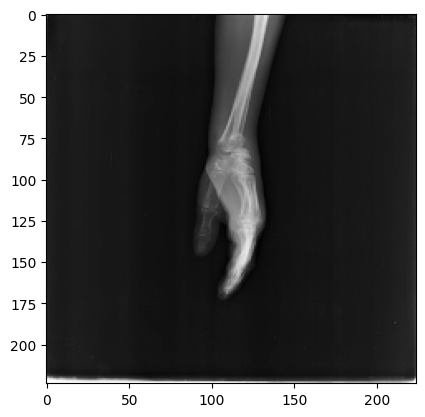

Fracture present: 1


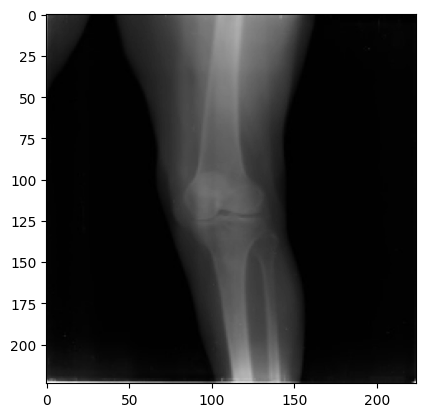

Fracture present: 0


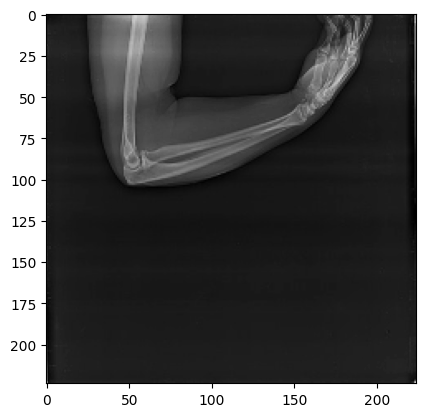

Fracture present: 0


In [22]:
# print some random examples from the training set
arr = random.sample(range(0, len(X_train)), 3)
for i in arr:
  plt.imshow(X_train[i], cmap='gray')
  plt.show()
  print("Fracture present:", y_train[i])

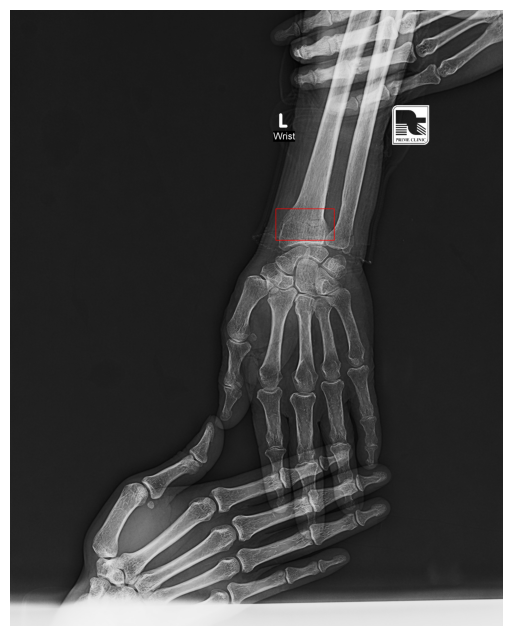

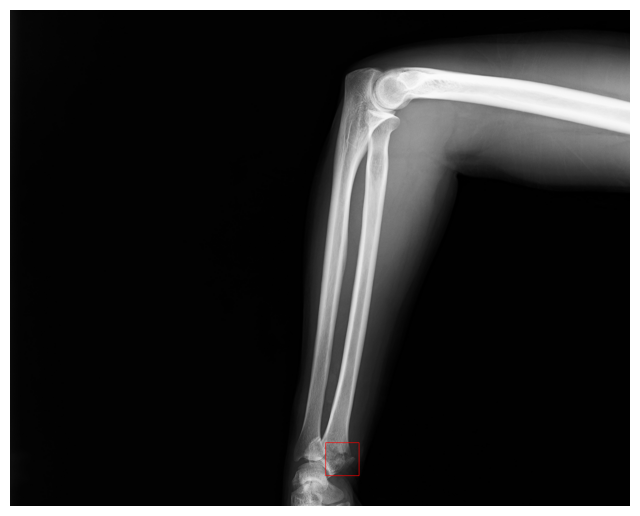

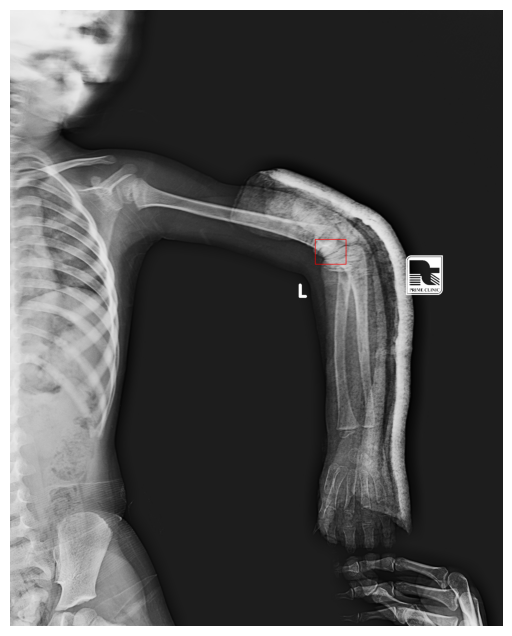

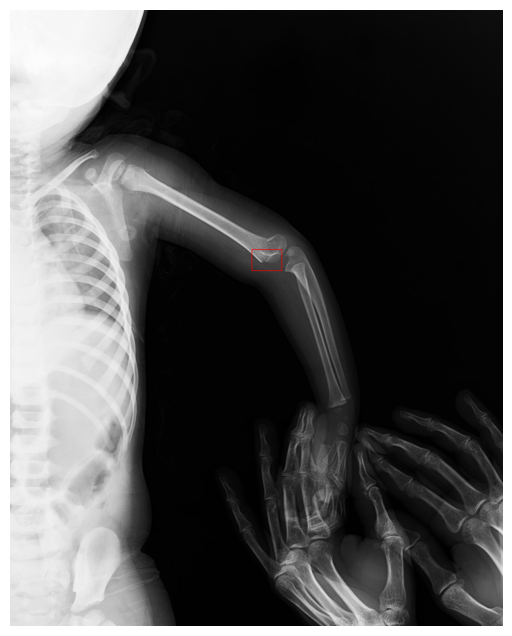

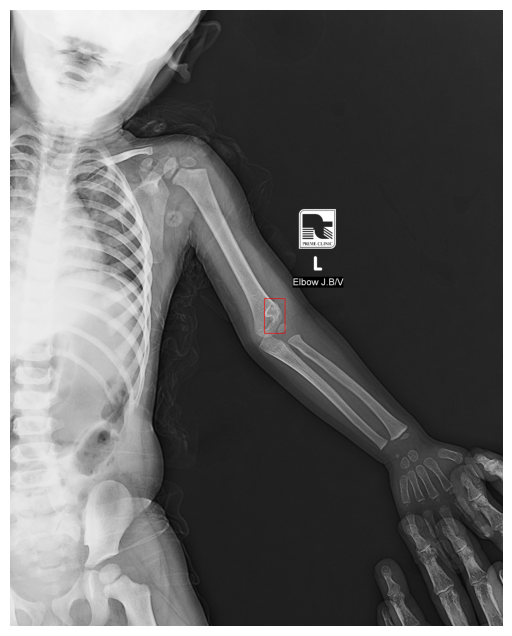

In [23]:
# Function to overlay bounding boxes on images
def draw_bounding_boxes(img_path, annotation_path, save_dir=None):
    # Loading the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # Checking if annotation exists
    if not os.path.exists(annotation_path):
        warnings.warn(f"Annotation file {annotation_path} not found. Skipping.")
        return None

    # Reading YOLO annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:

        # YOLO format: class_id, x_center, y_center, width, height (all relative)
        parts = line.strip().split()
        if len(parts) != 5:
            warnings.warn(f"Invalid annotation format in {annotation_path}. Skipping.")
            continue

        class_id, x_center, y_center, width, height = map(float, parts)

        # Converting relative coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculating box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.imsave(save_path, img)

    plt.show()

for img_path, label in zip(data_dict_old["inputs"][:5], data_dict_old["labels"][:5]):

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.txt')

    draw_bounding_boxes(img_path, annotation_path)

In [24]:
import tensorflow.keras as keras

In [25]:
# Parameters for the ViT
PATCH_SIZE = 16
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 4
MLP_DIM = 256
DROPOUT_RATE = 0.1
INPUT_SHAPE = (224, 224, 1)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE) * (INPUT_SHAPE[1] // PATCH_SIZE)
NUM_CLASSES = len(np.unique(y_train))

# Define patch and encoding layers
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# Build the Vision Transformer model
def create_vit_model():
    inputs = layers.Input(shape=INPUT_SHAPE)
    patches = Patches(PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, D_MODEL)(patches)

    for _ in range(NUM_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=D_MODEL, dropout=DROPOUT_RATE
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(MLP_DIM, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(DROPOUT_RATE)(x3)
        x3 = layers.Dense(D_MODEL)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(representation)

    model = Model(inputs=inputs, outputs=outputs)
    return model

vit_model = create_vit_model()
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patches (Patches)             │ (None, None, 256)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_encoder (PatchEncoder)  │ (None, 196, 128)          │          57,984 │ patches[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 196, 128)          │             256 │ patch_encoder[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 196, 128)          │         263,808 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 196, 128)          │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ patch_encoder[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 196, 128)          │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 196, 256)          │          33,024 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 196, 256)          │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 196, 128)          │          32,896 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 196, 128)          │               0 │ dense_2[0][0], add[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 196, 128)          │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 196, 128)          │         263,808 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 196, 128)          │               0 │ multi_head_attention_1[0]… │
│                               │                           │               

 Total params: 1,379,458 (5.26 MB)

 Trainable params: 1,379,458 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = vit_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 165s 623ms/step - accuracy: 0.5485 - loss: 0.7023 - val_accuracy: 0.6389 - val_loss: 0.6645
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 607ms/step - accuracy: 0.7115 - loss: 0.5802 - val_accuracy: 0.6528 - val_loss: 0.6652
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 610ms/step - accuracy: 0.8038 - loss: 0.4368 - val_accuracy: 0.6250 - val_loss: 0.8616
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 610ms/step - accuracy: 0.8651 - loss: 0.3284 - val_accuracy: 0.6667 - val_loss: 0.7875
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 611ms/step - accuracy: 0.9023 - loss: 0.2509 - val_accuracy: 0.5486 - val_loss: 1.1429
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 609ms/step - accuracy: 0.9197 - loss: 0.2179 - val_accuracy: 0.6319 - val_loss: 0.9676
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 607ms/step - accuracy: 0.9299 - loss: 0.1853 - val_accuracy: 0.6597 - val_loss: 0.9667
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 604ms/step - accuracy: 0.9431 -

In [27]:
# Evaluate on test data
test_loss, test_accuracy = vit_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6330 - loss: 1.7854
Test Loss: 1.678561806678772, Test Accuracy: 0.6527777910232544


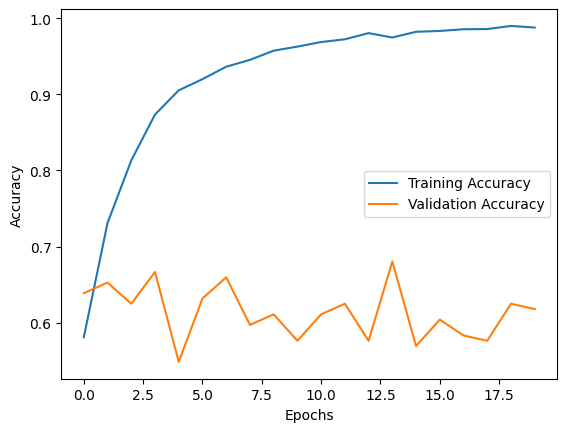

In [28]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()